In [1]:
# common imports
import math
import time
from tqdm import tqdm
import os

# graphing imports
import seaborn as sns
import matplotlib.pyplot as plt

# numpy and pandas import
import numpy as np
import pandas as pd

# sklearn import
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, r2_score, accuracy_score, f1_score


In [2]:
# Pytorch Imports
import torch
import torch.nn as nn
import torch.functional as f

from torch.utils.data import Dataset, TensorDataset, RandomSampler, DataLoader
from torch.optim import SGD

In [1991]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Common Functions

### Activation FN and Forward Pass Functions

In [3]:
class Sigmoid():

    def __init__(self,):
        self.type = 'Activation'
        self.name = 'Sigmoid'
    
    def forward(self,x_data):
        self.x = x_data
        self.probability = np.array( [ 1/(1+np.e**-x) for x in x_data] )
        # raise Exception(f' IN Sigmoid fn Forward pass : {self.probability.shape}') -> Test Passed
        return self.probability
    
    def backward(self, last_layer_grad, output_layer = False):

        if not output_layer :
            self.grad = np.multiply(last_layer_grad, np.array([ probability*(1 - probability) for probability in self.probability]) )
            # raise Exception(f' IN Sigmoid fn Backward pass and gradient shape is : {self.grad.shape}') -> Test
            return [self.grad]
        
        else:
            self.grad = (self.probability - last_layer_grad)/len(self.probability) 
            raise Exception(f' IN Sigmoid fn Backward pass and gradient shape is : {self.grad.shape}')
            return [self.grad]

In [4]:
class Tanh():

    def __init__(self,):
        self.type = 'Activation'
        self.name = 'Tanh'
    
    def forward(self, x_data):
        self.x = x_data
        self.probability = np.array( [ np.tanh(x) for x in x_data] )
        # print(self.probability)
        # raise Exception(f' IN Tanh fn Forward pass : {self.probability.shape}') -> Passed
        return self.probability
    
    def backward(self, last_layer_grad):
        self.grad = np.multiply(last_layer_grad, np.array( [ (1 - probability**2) for probability in self.probability] ) )
        # raise Exception(f' IN Tanh fn Backward pass and gradient shape is : {self.grad.shape}') -> Test Passed
        return [self.grad]

In [263]:
# np.array(list(map(bool,np.array([1,1,1,1])))) - 0

In [5]:
class ReLU():

    def __init__(self,):
        self.type = 'Activation'
        self.name = 'ReLU'
    
    def forward(self, x_data):
        self.x = x_data
        self.y = np.array([np.maximum(0.0,x) for x in x_data])
        # print(self.x[0], self.y[0])
        # raise Exception(f' IN ReLU fn Forward pass : {self.y.shape}') -> Test Passed
        return self.y
    
    def backward(self,last_layer_grad):
        # Here we are doing the element wise product
        self.e = self.y.copy()
        self.e[self.e > 0] = 1
        self.grad = np.multiply(last_layer_grad,  self.e )
        # raise Exception(f' IN ReLU fn Backward pass and gradient shape is : {self.grad.shape} and \n {self.e} and \n {self.e.shape}') # -> Test Passed
        return [self.grad]

In [6]:
class Softmax():

    def __init__(self):
        self.type = 'Activation'
        self.name = 'SoftMax'
    
    def forward(self, x_data):

        self.x = x_data.astype(np.float64) # if we don't convert into float wills how error
        self.probability = np.array([np.exp(x)/sum(np.exp(x)) for x in self.x])
        # raise Exception(f' IN Softmax fn Forward pass : {self.probability.shape}') -> Passed
        return self.probability
    
    def backward(self, y_true):
        '''Warning :' Softmax backward only works with Cross Entropy loss as Loss Fn ") '''
        # self.grad = np.array([ np.dot(y_true,y)*(y_true-y) for y in self.probability ])
        self.grad = (self.probability - y_true)/len(y_true)
        # raise Exception(f' IN Softmax fn Backward pass and gradient shape is : {self.grad.shape}') -> Passed
        return [self.grad]

In [8]:
class Linear():

    def __init__(self, w):

        self.type = 'Linear'
        self.name = 'Forward_Linear'
        self.w = w
        self.previous_grads = 0
    
    def forward(self, x_data):
        self.x = np.append( x_data, np.array([[1]]*len(x_data)) , axis = 1)
        self.y = self.x@self.w
        # raise Exception(f" In the Forward Pass of the Linear Forward class : {self.y.shape} and {self.x}") # -> Tested Passed 
        return self.y
    
    def backward(self, last_layer_grad):
        # print(self.x.transpose().shape, last_layer_grad.shape, self.w.shape, self.w[:-1].transpose().shape)
        # self.grad = np.array( [self.x[i].transpose()@last_layer_grad[i] for i in range(len(self.x)) ] )
        self.grad_w = self.x.transpose()@last_layer_grad
        self.grad_a = last_layer_grad@self.w[:-1].transpose()

        # raise Exception(f' IN Tanh fn Backward pass and gradient shape is : {self.grad2.shape} and {self.grad3.shape} ') -> Test Passed
        return [self.grad_a,self.grad_w]
    
    def weight_update(self, momentum=0, lr=1e-4):
        w_grad = momentum * self.previous_grads + self.grad_w

        # storing previous grads for further use
        self.previous_grads = w_grad

        # Doing weight update here
        self.w -= lr*w_grad

In [9]:
class CE_Loss():

    def __init__(self, y_pred, y_true):

        self.type = 'Loss'
        self.name = 'Cross Entropy Loss'
        
        self.y_pred =  y_pred
        self.y_true = y_true
    
    def calculate_loss(self):

        log_prob = np.log(self.y_pred)
        # calculating the Cross_Entropy_Loss
        loss = -sum([np.dot(log_prob[i],self.y_true[i]) for i in range(len(self.y_true))])
        return loss
    
    def Gradient(self):
        grad = (self.y_pred - self.y_true)/len(self.y_pred)
        return self.y_true

In [10]:
class MSE_Loss():

    def __init__(self, y_pred, y_true):

        self.type = 'Loss'
        self.name = 'Mean Squared Loss'

        self.y_pred =  y_pred
        self.y_true = y_true
    
    def calculate_loss(self):

        # Calculating loss
        loss = sum( ((self.y_pred - self.y_true)**2 ).reshape(-1) )/len(self.y_pred)
        return loss
    
    def Gradient(self):
        grad = (self.y_pred - self.y_true)/len(self.y_pred)
        return grad

In [11]:
def calculate_r2(y_true, y_pred):

    y_pred = y_pred.reshape(-1)
    y_true = y_true.reshape(-1)

    # calculating r2 
    # print(y_pred.shape)
    score = max( -1, r2_score(y_true, y_pred) )
    return score

In [12]:
def calculate_f1(y_true, y_pred):

    y_pred = np.argmax( y_pred, axis = 1 )
    y_true = np.argmax( y_true, axis = 1 )

    # raise Exception(f' {y_true.shape} and {y_true} and \n {y_pred} {y_pred.shape}') Test Passed

    # calculating r2 
    score =  f1_score(y_true, y_pred) 
    return score

In [14]:
def calculate_accuracy(y_true, y_pred, confusion = False):

    y_pred = np.argmax( y_pred, axis = 1 )
    y_true = np.argmax( y_true, axis = 1 )

    # calculating r2 
    score = accuracy_score(y_true, y_pred)

    if confusion:
        conf_mat = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize =(8,8))
        sns.heatmap(conf_mat, annot=True)
        plt.plot()

        return score, conf_mat
    
    return score

***We have defined, every Activation functions and linear pass functions with it's gradient function also*** 

### Creating a NN architecture with the above defined functions

In [15]:
# example architecture is : [10, 32, {'Activation':ReLU()}, 65, 10, {'Activation':Softmax()} ]
# Activation Fn should be given as a dictionary ( & class ) and Neurons should be of integers

class Python_NN():

    def __init__(self, name, arch):

        self.name = name
        self.arch = arch
        self.w = []
        print(f" Don't give starting value as a activation, If you have given remove it please (Just a default warning) ")
    
    def create_network(self,):

        # Here we are initializing the weights of the network 
        # Idea is create a array of weights and then make a forward 

        dim1 = self.arch[0]
        for i in range(1,len(self.arch)):  

            if type(self.arch[i]) != dict :
                dim2 = self.arch[i]
                
                # restricting initialization to avoid numeric overflow during sigmoid and tanh
                # +1 to add a bias term to it
                self.w.append( Linear( np.clip(np.random.randn( dim1+1, dim2),-0.1,0.1) ))
                dim1 = dim2
            
            else:
                # Adding the activation fn
                self.w.append(self.arch[i]['Activation'])
    
    def make_forward_pass(self,x):
        
        # The Model accepts inputs , (1xn) -> column vec and convert this into (1xm) in each forward pass
        # The Forward model is like this (1xn) x (nXm) = (1xm) , (1xm) x (mxp) => (1xp) .... (1xk) x (k x j) = (1 x j) [Our Output]
        weight_idx = 0
        w_class = self.w[weight_idx]
        y = x.copy()

        for i in range(1,len(self.arch)):
            
            # if type(self.arch[i]) != dict :

            #     # changing  the weights 
            #     w_class = self.w[weight_idx]

            #     # forward pass
            #     y = w_class.forward(y)
            #     weight_idx += 1
            #     # print(y.shape, weight_idx)
                
            #     # raise Exception(f" In the non-activation section of forward Fn and shape of y is : {y.shape}") -> Passed

            # elif type(self.arch[i]) == dict:

            #     w_class = self.w[weight_idx]
            #     y = w_class.forward(y)

            #     # y = self.arch[i]['Activation'].forward(y)
            #     weight_idx += 1
            #     # raise Exception(f" In the Activation section of forward Fn and shape of y is : {y.shape}") -> Test Passed

            
            # changing  the weights 
            w_class = self.w[weight_idx]

            # forward pass
            y = w_class.forward(y)
            weight_idx += 1

        
        self.y = y
        return y
    
    def backward(self, final_layer_error_grad, ):
        
        # Here in the place of final layer error grad :
        # We need to give y_true if Final Layer is softmax & Cross Entropy
        # We need to give (y^ - y_true) if MSE_Loss

        ''' Note : ==== Right Now only supports Cross Entropy loss with Softmax and Won't support MSE error with softmax as it is Out of the scope of the assignment '''
        # For other combinations, error may arise as they are out os scope of our assignment

        Last_Layer_Grad = final_layer_error_grad
        grads = []

        for i in reversed(range(len(self.w))):
                
                dw = self.w[i].backward(Last_Layer_Grad)
                Last_Layer_Grad = dw[0]
                
                # if len(dw) == 2:
                #     grads.append(dw[1])
        
        # self.gradients = grads
    
    def optimize_weights(self, momentum=0, lr=1e-5):
        
        for j in self.w :

            if j.type == 'Linear':
                j.weight_update(momentum, lr)
                    
        # print(len(grads))

In [16]:
NN1 = Python_NN('Network1', [2, 32, 64, {'Activation':Sigmoid()}, 128, {'Activation':ReLU()}, 256, {'Activation':ReLU()}, {'Activation':Tanh()},2])
NN1.create_network()

 Don't give starting value as a activation, If you have given remove it please (Just a default warning) 


In [17]:
x1 = np.array( [ [1,7] ]*1024 )

k = NN1.make_forward_pass(x1)
k.shape

(1024, 2)

In [18]:
error = np.array( (x1 - np.array( [ [1,3] ]*1024 )) )/len(x1)
error.shape

(1024, 2)

In [19]:
NN1.backward(error)

# Question - 1

## XOR Implementation

In [20]:
data = np.array([[x,y,bool(x+y) - x*y] for x in [0,1] for y in [0,1]])
data

array([[0, 0, 0],
       [0, 1, 1],
       [1, 0, 1],
       [1, 1, 0]])

In [561]:
class Network_For_XOR():

    def __init__(self, x_data=data[:,:-1], y_data=data[:,-1]):

        self.x = x_data
        self.y = np.array([[0,1] if i else [1,0] for i in y_data])
        print(f" This is specially implemented for XOR ")

        # Adding a Bias Term
        self.x = np.append(self.x, np.array([[1]]*len(self.x)) , axis = 1)
        self.previous_step = [np.zeros((3,2)) , np.zeros((3,2))  ]

    def initialize_network(self):
        self.w = [ np.clip( np.random.randn( 3,2 ) , -2, 2 ), np.clip(np.random.randn( 3,2 ), -2, 2) ]
    
    def forward(self,x):
        self.x = x

        # Adding a bias Term Here
        self.x1 = np.append( self.x@self.w[0], np.array([[1]]*len(self.x)) , axis = 1)

        # print(self.x1.shape, self.w[1].shape)
        self.x_Relu = np.array([np.maximum(0,x) for x in self.x1])

        self.x2 = self.x_Relu@self.w[1]

        # if np.max(self.x2 > 20):
        #     print(self.w,'\n\n\n', np.max(self.w[0]), np.max(self.w[1]) , '\n\n')
        #     print(self.x2 , '\n\n' , np.exp(self.x2  ), np.sum( np.exp(self.x2) , axis = 1).reshape(4,1) )
        #     raise Exception(" Weights Got increased so much, restart to avoid overflow -> Warning ")
        
        self.x3 = np.exp(self.x2  )/( np.sum( np.exp( self.x2  ), axis = 1).reshape(4,1) )

        # print(self.x3.shape)
        # raise Exception(f" Test in forward pass {self.x3} and {np.sum(self.x3, axis = 1)}")
        return self.x3
    
    def backward(self,y_true):

        # creating a dw array
        # we will fill that during back prop
        self.dw = [0,0]

        # calculating the gradients
        res = (self.x3 - y_true)/len(self.x3)

        # print(self.x_Relu.transpose() )
        self.dw[1] = np.clip( self.x_Relu.transpose()@res, -5, 5 )

        # print(res.shape, self.w[-1][:-1].transpose().shape)
        # print(self.w[-1], '\n', self.x2 )
        
        grad_a = res@self.w[1][:-1].transpose()

        # print(grad_a.shape, self.x1[:,:-1] )

        # print(grad_a,'\n\n',  self.x1[:,:-1] )

        self.e = self.x1[:,:-1].copy()
        self.e[self.e > 0] = 1

        grad_a = np.multiply(grad_a, self.e )

        # print(grad_a)
        self.dw[0] = np.clip( self.x.transpose()@grad_a, -1, 1 )

        # print(grad_a, self.dw[0].shape, self.dw[1].shape)
    
    def optimizer_step(self, momentum = 0, lr=1e-3, gamma = 0.0 ):   
        # Making an optimizer step using simple gradient descent

        self.w[0] = np.clip(self.w[0] - (momentum*self.previous_step[0] + self.dw[0]*lr + gamma*self.w[0] ) , -5, 5 )
        self.w[1] = np.clip(self.w[1] - (momentum*self.previous_step[1] + self.dw[1]*lr + gamma*self.w[1] ) , -5, 5 )

        self.previous_step[0] =  (momentum*self.previous_step[0] + self.dw[0]*lr )
        self.previous_step[1] =  (momentum*self.previous_step[1] + self.dw[1]*lr )
    
    def CE_Loss(self, y_true, y_pred):
        
        # For stability we are adding 1e-4
        log_prob_1 = np.log( y_pred + 1e-4 )

        # (4x2) . (4x2) -> element wise multiplication
        # print(log_prob_1[0], y_true )
        
        loss = - sum([ np.dot(y_true[i],log_prob_1[i]) for i in range(4) ])/len(y_true)
        # print(loss, loss.shape)
        return loss
    
    def train_data(self, epochs, momentum = 0, lr=1e-3, gamma = 0.0, graph_enabled=True, print_freq=100):

        # For keep in track of loss
        loss_list = []
        score_list = []
        self.initialize_network()
        print(f" If weight Initialization is bad , we reinitialize it after 400 epochs ")

        for e in tqdm(range(epochs)):
            
            # Forward Pass
            y_pred = self.forward(self.x)

            # Loss Calc
            loss = self.CE_Loss(self.y, y_pred)

            # Back Prop
            self.backward(self.y)

            # Gradient Descent
            self.optimizer_step(momentum , lr, gamma)

            # appending loss
            loss_list.append(loss)

            # calculating score
            score = f1_score(np.argmax(self.y, axis=1), np.argmax(y_pred, axis=1) )*100
            score_list.append(score)

            if (e+1) % 400 == 0:
                loss_list = []
                score_list = []
                self.initialize_network()

            if score >= 100 :
                # if maximum score is achieved , we are stopping learning
                break

            if (e+1) % print_freq == 0:
                print(f" Total Loss in epoch : {e} is : {loss:.3f}")
                print(f" prediction in epoch {e} : {np.argmax(y_pred, axis=1)} and f1_score is : {f1_score(np.argmax(self.y, axis=1),np.argmax(y_pred, axis=1))*100:.3f} ")
                # break
        
        print(f" Total Loss in final epoch : {e} is : {loss_list[-1]:.3f}")
        # print(np.argmax(y_pred, axis=1), y_pred)
        print(f" prediction in final epoch {e} : {np.argmax(y_pred, axis=1)} and f1_score is : {f1_score(np.argmax(self.y, axis=1),np.argmax(y_pred, axis=1))*100:.3f} ")

        # print(self.w[0], '\n\n', self.w[1])

        if graph_enabled:
            
            plt.figure(figsize = (14,6) )

            plt.subplot(1,2,1)
            plt.xlabel(F" Epochs ")
            plt.ylabel(F" Loss ")
            plt.plot(loss_list)

            plt.subplot(1,2,2)
            plt.xlabel(F" Epochs ")
            plt.ylabel(F" F1_score ")
            plt.plot(score_list)
            plt.show()

            # print(f" Plotting the graph ")
            # w1 = self.w[1][:,0]
            # w2 = self.w[1][:,1]

            # points1 = np.linspace(-1,2,100)*(-w1[0]/w1[1]) + (-w1[2]/w1[1])
            # points2 = np.linspace(-1,2,100)*(-w2[0]/w2[1]) + (-w2[2]/w2[1])

            # plt.figure(figsize = (12,6) )
            # print(self.x)
            # plt.plot(self.x[:,0], self.x[:,1] , 'o', label = 'points')
            # plt.plot(np.linspace(-1,2,100), points1, label='line1')
            # plt.plot(np.linspace(-1,2,100), points2, label='line2')
            # plt.legend(loc='best')
            # plt.show()


 This is specially implemented for XOR 


 This is specially implemented for XOR 
 If weight Initialization is bad , we reinitialize it after 400 epochs 


  5%|▍         | 238/5000 [00:00<00:02, 1738.22it/s]

 Total Loss in final epoch : 238 is : 0.477
 prediction in final epoch 238 : [0 1 1 0] and f1_score is : 100.000 


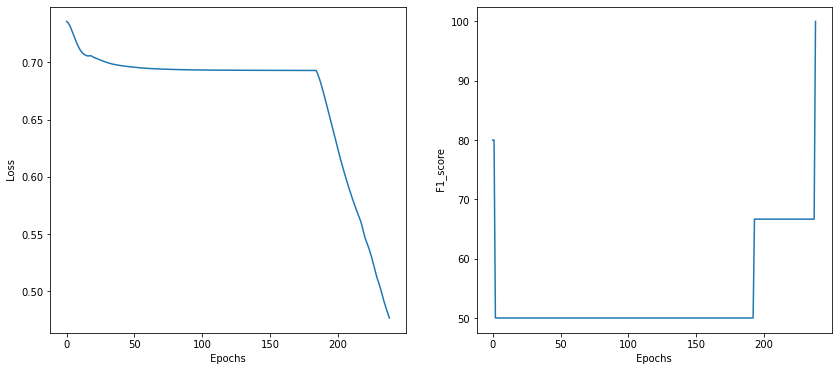

In [586]:
XOR_NN = Network_For_XOR()
XOR_NN.train_data(5000, 0.9, 1e-2, 0.00, print_freq = 5000)

## Question - 2

In [1963]:
data = pd.read_excel('Concrete_Data.xls')

train_df = data.drop(['Concrete compressive strength(MPa, megapascals) '], axis = 1, inplace = False)
target = data['Concrete compressive strength(MPa, megapascals) ']

data.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [2217]:
data.shape

(1030, 9)

In [2218]:
data.describe()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


In [2219]:
train, test, y_train, y_test = train_test_split(train_df, target, test_size = 0.2, shuffle = True , random_state = 10)
train, val, y_train, y_val = train_test_split(train, y_train, test_size = 0.25, shuffle = True, random_state = 15)

In [2220]:
print(f" percent of the train data in the whole data : {len(train)*100/len(train_df):.2f} %")
print(f" percent of the test data in the whole data : {len(test)*100/len(train_df):.2f} %")
print(f" percent of the val data in the whole data : {len(val)*100/len(train_df):.2f} %")

 percent of the train data in the whole data : 60.00 %
 percent of the test data in the whole data : 20.00 %
 percent of the val data in the whole data : 20.00 %


In [2221]:
Normalized_train = ( train - train.mean() )/train.std()
Normalized_test = ( test- train.mean() )/train.std()
Normalized_val = ( val - train.mean() )/train.std()

In [2222]:
class Python_MLP():

    def __init__(self, x_data = Normalized_train.to_numpy(), y_data = y_train.to_numpy().reshape(len(y_train),1), test = Normalized_test.to_numpy(), 
                 y_test = y_test.to_numpy().reshape(len(y_test),1), val = Normalized_val.to_numpy(), y_val = y_val.to_numpy().reshape(len(y_val),1), ):

        self.x = x_data
        self.y = y_data

        self.test, self.y_test = test, y_test
        self.val, self.y_val = val, y_val
    
    def prepare_data(self, batch_size=64, normalize = False):

        if normalize :
            # getting the std and mu of the data
            mu = np.mean(self.x, axis = 0)
            std = np.std(self.x, axis = 0)

            # Now normalizing the data
            self.x = (self.x - mu ) / (std)
            self.val = (self.val - mu )/(std)
            self.test = (self.test - mu )/(std)
        
        self.batched_data = [self.x[i:i+batch_size] for i in range(0,len(self.x),batch_size)]
        self.batched_y = [self.y[i:i+batch_size] for i in range(0,len(self.x),batch_size)]
    
    def create_network(self, arch):
        self.arch = arch
        self.network = Python_NN('network-1', self.arch)
        self.network.create_network()
    
    def train_data(self, epochs, momentum = 0, lr = 1e-4, print_freq = 1000, score_fn = calculate_r2, Loss = MSE_Loss):

        loss_list = []
        val_loss_list = []

        train_score = []
        val_score = []
        
        print(f" Just an Info, The error and activation Function should be :- Cross Entropy + Softmax (or) BCE + Sigmoid (or) MSE + Linear ")

        for e in tqdm( range(epochs) ):

            epoch_loss = 0
            val_loss = 0

            for x,y_true in zip(self.batched_data, self.batched_y):
                
                x = x.astype(np.float64)

                y_pred = self.network.make_forward_pass(x)
                # y_true = y_true.reshape((len(y_true),1))
                
                # calculating loss
                Loss_fn = Loss(y_pred, y_true)
                loss = Loss_fn.calculate_loss()

                # Gradient
                grad = Loss_fn.Gradient()

                # back_prop
                self.network.backward(grad)

                # Gradient updation
                self.network.optimize_weights(momentum, lr)

                epoch_loss += loss

            ''' Now Calculating the Val Loss '''

            val_pred = self.network.make_forward_pass(self.val)

            # creating a Val Fn 
            val_Loss_fn = Loss(val_pred, self.y_val)
            val_loss += val_Loss_fn.calculate_loss()

            # loss list 
            loss_list.append(epoch_loss/len(self.x))
            val_loss_list.append(val_loss)

            train_score.append(score_fn( self.y, self.network.make_forward_pass(self.x) )) 
            val_score.append(score_fn( self.y_val, self.network.make_forward_pass(self.val) ))

            if (e+1) % print_freq == 0: 

                print(f" The current epoch : {e+1} ")
                print(f" Train score and Loss : '{train_score[-1]*100:.3f}' & '{loss_list[-1]:.3f}' and val score and Loss : '{val_score[-1]*100:.3f}' & '{val_loss_list[-1]:.3f}' ")
        
        # prediction in Train Dataset
        y_true_full = self.y
        y_pred_full = self.network.make_forward_pass(self.x)

        # prediction in Val Dataset
        y_val_true = self.y_val
        y_val_pred = self.network.make_forward_pass(self.val)

        # prediction in Test Dataset
        y_test_true = self.y_test
        y_test_pred = self.network.make_forward_pass(self.test)

        # Printing the predictions

        # print(y_val_true.shape, y_val_pred.shape)

        print(f" Final R2 score is : {score_fn(y_true_full, y_pred_full)*100:.3f} % in Train Dataset ")
        print(f" Final epoch Train loss : {loss_list[-1]} \n")

        print(f" Final R2 score is : {score_fn(y_val_true, y_val_pred)*100:.3f} % in Val Dataset ")
        print(f" Final epoch Val loss : {val_loss_list[-1]} \n")

        print(f" Final R2 score is : {score_fn(y_test_true, y_test_pred)*100:.3f} % in Test Dataset ")
        print(f" Final epoch Test loss : {Loss(y_test_pred, y_test_true).calculate_loss()} \n")

        self.loss_list = loss_list
        self.val_loss_list = val_loss_list

        self.train_score = train_score
        self.val_score = val_score
    
    def plot_training_curve(self, Loss_type = 'MSE_Loss', score_metric = 'R2_Score'):

        loss_list = self.loss_list
        val_loss_list = self.val_loss_list

        val_score = self.val_score
        train_score = self.train_score

        plt.figure(figsize=(18,14))
        
        plt.subplot(2,2,1)
        plt.xlabel('Epochs')
        plt.ylabel(f'Train_{Loss_type}')
        plt.title(f'Train {Loss_type} vs Epochs')
        plt.plot(loss_list, 'b', label = f'Train Loss')
        plt.legend(loc='best')

        plt.subplot(2,2,2)
        plt.xlabel('Epochs')
        plt.ylabel(f'Val_{Loss_type}')
        plt.title(f'Val {Loss_type} vs Epochs')
        plt.plot(val_loss_list, 'orange', label = 'Val Loss')
        plt.legend(loc='best')

        plt.subplot(2,2,3)
        plt.xlabel('Epochs')
        plt.ylabel(f'Train_{score_metric}')
        plt.title(f'Train {score_metric} vs Epochs')
        plt.plot(train_score, 'b', label = f'Train {score_metric}')
        plt.legend(loc='best')

        plt.subplot(2,2,4)
        plt.xlabel('Epochs')
        plt.ylabel(f'val_{score_metric}')
        plt.title(f'Val {score_metric} vs Epochs')
        plt.plot(val_score, 'orange', label = f'val {score_metric}')
        plt.legend(loc='best')
        plt.show()

        # print(val_score == train_score)

In [2223]:
two_layer_arch = [8, 64, {'Activation':ReLU()}, 8,{'Activation':ReLU()}, 1]
arch1 = [8, 32, 64, {'Activation':Sigmoid()}, 128, {'Activation':ReLU()}, 256, {'Activation':ReLU()}, {'Activation':Tanh()},128,64,1]

In [2239]:
N1 = Python_MLP()

# creating network arch
N1.create_network(two_layer_arch)

N1.prepare_data(64)

 Don't give starting value as a activation, If you have given remove it please (Just a default warning) 


In [2242]:
N1.train_data( 500, momentum=0.2, lr=1e-3 )

 Just an Info, The error and activation Function should be :- Cross Entropy + Softmax (or) BCE + Sigmoid (or) MSE + Linear 


100%|██████████| 500/500 [00:03<00:00, 151.52it/s]

 Final R2 score is : 97.349 % in Train Dataset 
 Final epoch Train loss : 0.129421678691511 

 Final R2 score is : 88.526 % in Val Dataset 
 Final epoch Val loss : 29.239828285083117 

 Final R2 score is : 88.908 % in Test Dataset 
 Final epoch Test loss : 30.823920634722985 



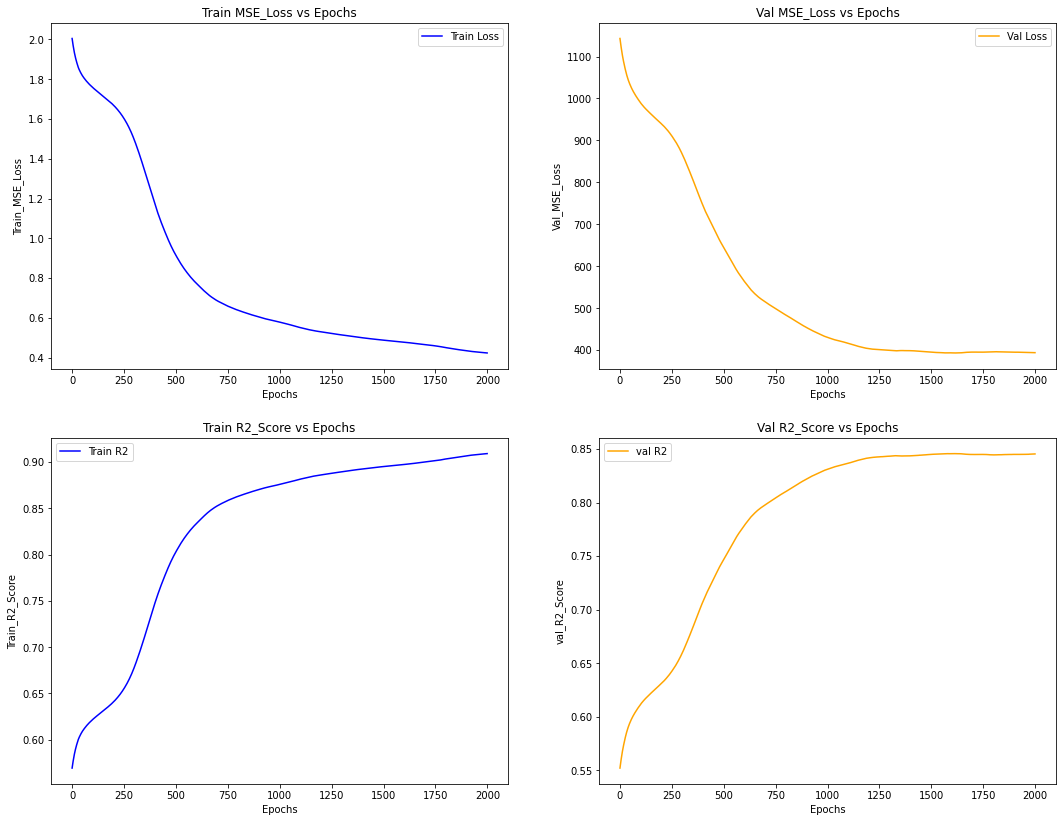

In [1294]:
N1.plot_training_curve()

## Doing Pytorch Implementation 

In [2231]:
class Pytorch_Model(nn.Module):

    def __init__(self, input_dim=8, output_dim=1):
        super(Pytorch_Model, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.dense_layer1 = nn.Sequential(

            nn.Linear(self.input_dim, 64),
            nn.ReLU(),

            nn.Linear(64,8),
            nn.ReLU(),

            nn.Linear(8,self.output_dim),
        )
    
    def forward(self, x, classification=False):
        
        y = self.dense_layer1(x)
        
        # If that is a classification task
        if classification:
            y = nn.Softmax(y, dim=1)

        return y

In [2232]:
Model1 = Pytorch_Model().to(device)
print(f" Total trainable parameters in the model is : {sum([p.numel() for p in Model1.parameters()])} ")

 Total trainable parameters in the model is : 1105 


In [2233]:
class Pytorch_NN():

    def __init__(self, x_data, y_data, x_val, y_val, x_test, y_test, optimizer=SGD, model=Model1, device=device, lr=1e-3, momentum=0.2, loss=nn.MSELoss()):
        
        # Datasets
        self.x = x_data
        self.y = y_data
        
        self.val = x_val
        self.y_val = y_val

        self.test = x_test
        self.y_test = y_test

        self.device = device

        # Initializing Optimizers , Models and loss
        self.loss = loss
        self.model = model.to(device)
        self.optimizer = optimizer(self.model.parameters(), lr = lr, momentum = momentum )
    
    def create_Dataloader(self, x, y):
        
        Tensor_Data = TensorDataset(x,y)
        # Random_Data_Sampler = RandomSampler(Tensor_Data)
        dataloader = DataLoader(dataset = Tensor_Data, batch_size=self.batch_size, shuffle = True, drop_last = False)
        return dataloader
    
    def prepare_data(self, batch_size=64, normalize=False):

        self.batch_size = batch_size

        if normalize:
            # getting the std and mu of the data
            mu = np.mean(self.x, axis = 0)
            std = np.std(self.x, axis = 0)

            # Now normalizing the data
            self.x = (self.x - mu ) / (std)
            self.val = (self.val - mu )/(std)
            self.test = (self.test - mu )/(std)
        
        # converting them into torch tensor
        self.x, self.y = torch.tensor(self.x, dtype = torch.float32).to(device), torch.tensor(self.y).to(device)
        self.val, self.y_val = torch.tensor(self.val, dtype = torch.float32).to(device), torch.tensor(self.y_val).to(device)
        self.test, self.y_test = torch.tensor(self.test, dtype = torch.float32).to(device), torch.tensor(self.y_test).to(device)

        # Creating a DataLoader with Batched Data
        self.Train_DataLoader = self.create_Dataloader(self.x, self.y)
        # self.Val_DataLoader = self.create_Dataloader(self.val, self.y_val)
        # self.Test_DataLoader = self.create_Dataloader(self.test, self.y_test)
    
    def train_model(self, epochs, print_freq, score_fn, classification=False):

        train_loss_list, val_loss_list = [], []
        train_score, val_score = [], []

        for e in tqdm(range(epochs)):
            epoch_loss = 0
            val_loss = 0

            for index,batch in enumerate(self.Train_DataLoader):

                x,y_true = batch

                # Moving data to device
                x = x.to(self.device)
                y_true = y_true.to(self.device)

                # getting output from the model
                y_pred = self.model(x, classification = classification)

                # print(y_pred.dtype)

                # calculating the loss
                loss = self.loss(y_pred, y_true)

                # doing back_prop
                loss.backward()

                # updating weights
                self.optimizer.step()
                self.optimizer.zero_grad()

                epoch_loss += loss.item()*len(x)
            
            # Now calculating the loss for val loss
            # print(self.val.dtype)
            val_pred = self.model(self.val)
            y_pred = self.model(self.x)

            val_loss = self.loss(val_pred, self.y_val).item()

            # collecting the loss and score for each epoch
            val_loss_list.append(val_loss)
            train_loss_list.append(epoch_loss/len(self.x))

            v_score = score_fn(self.y_val.detach().cpu().numpy(), val_pred.detach().cpu().numpy())
            t_score = score_fn(self.y.detach().cpu().numpy(), y_pred.detach().cpu().numpy())

            train_score.append(t_score)
            val_score.append(v_score)

            if (e+1)% print_freq == 0:
                print("==================================================================================")
                print(f" Current epoch is : {e+1} ")
                print(f" The score and Loss in Validation Data is : {val_score[-1]*100:.3f} and {val_loss_list[-1]:.2f} ")
                print(f" The score and Loss in Train Data is : {train_score[-1]*100:.3f} and {train_loss_list[-1]:.3f} ")
                print("===================================================================================\n")
        
        # Calculating Results in Test Data

        test_pred = self.model(self.test)
        test_loss = self.loss(test_pred, self.y_test).item()
        test_score = score_fn(self.y_test.detach().cpu().numpy(), test_pred.detach().cpu().numpy())
        
        print("****************************************************************************************")
        print(f" Final Epoch Results ")
        print(f" The score and Loss in Validation Data is : {val_score[-1]*100:.2f} and {val_loss_list[-1]:.2f} ")
        print(f" The score and Loss in Train Data is : {train_score[-1]*100:.3f} and {train_loss_list[-1]:.3f} ")
        print(f" The score and Loss in Test Data is : {test_score*100:.3f} and {test_loss:.3f} ")
        print("****************************************************************************************\n")

In [2234]:
concrete_data = pd.read_excel('Concrete_Data.xls')

concrete_train_df = concrete_data.drop(['Concrete compressive strength(MPa, megapascals) '], axis = 1, inplace = False).to_numpy().astype(np.float32)
concrete_target = data['Concrete compressive strength(MPa, megapascals) '].to_numpy().reshape((len(concrete_train_df),1)).astype(np.float32)

In [2235]:
concrete_target.shape

(1030, 1)

In [2236]:
c_train, c_test, c_y_train, c_y_test = train_test_split(concrete_train_df, concrete_target, test_size = 0.2, shuffle = True , random_state = 10)
c_train, c_val, c_y_train, c_y_val = train_test_split(c_train, c_y_train, test_size = 0.25, shuffle = True, random_state = 15)

In [2237]:
Pytorch_Train = Pytorch_NN(x_data=c_train, y_data=c_y_train, x_val=c_val, y_val=c_y_val, x_test=c_test, y_test=c_y_test, )
Pytorch_Train.prepare_data(normalize=True)

In [587]:
Pytorch_Train.train_model(2000,500,calculate_r2)

NameError: name 'Pytorch_Train' is not defined

## Now feeding XOR data

In [1887]:
XOR_data = np.array([[x,y,bool(x+y) - x*y] for x in [0,1] for y in [0,1]], dtype = np.float64)
XOR_MSE = XOR_data[:,-1].reshape(4,1)

XOR_x = XOR_data[:,:-1]
XOR_y = np.array([ [0,1] if c else [1,0] for c in XOR_data[:,-1] ] , dtype = np.float64)

XOR_x

array([[0., 0.],
       [0., 1.],
       [1., 0.],
       [1., 1.]])

In [1933]:
XOR_arch = [2, 2, {'Activation':ReLU()}, 2, {'Activation':Softmax()} ]
XOR_arch2 = [2, 4, {'Activation':ReLU()}, 2, {'Activation':Softmax()}]

In [1940]:
XOR = Python_MLP(x_data= XOR_x, y_data = XOR_y, test = XOR_x, 
                 y_test = XOR_y , val = XOR_x, y_val = XOR_y,)

# creating network arch
XOR.create_network(XOR_arch)

XOR.prepare_data(4)

 Don't give starting value as a activation, If you have given remove it please (Just a default warning) 


In [1942]:
XOR.train_data(500, momentum=0.0, lr=1e-1, score_fn = calculate_f1, Loss = CE_Loss, print_freq=1e6)

 Just an Info, The error and activation Function should be :- Cross Entropy + Softmax (or) BCE + Sigmoid (or) MSE + Linear 


100%|██████████| 500/500 [00:00<00:00, 1081.13it/s]

 Final R2 score is : 100.000 % in Train Dataset 
 Final epoch Train loss : 0.02809023455129083 

 Final R2 score is : 100.000 % in Val Dataset 
 Final epoch Val loss : 0.11209546295982772 

 Final R2 score is : 100.000 % in Test Dataset 
 Final epoch Test loss : 0.11209546295982772 



In [1106]:
np.exp(np.array([[0.3,0.94444],[0.6,0.4]], dtype = float))

array([[1.34985881, 2.57137301],
       [1.8221188 , 1.4918247 ]])

## Now Trying with the Iris Dataset

In [1641]:
from sklearn import datasets

iris = datasets.load_iris()
iris_data = iris['data']
iris_target = iris['target']

In [1741]:
target = np.zeros((150,3))
for i in range(150): target[i][iris_target[i]] = 1

# sample
target[-1]

array([0., 0., 1.])

In [1810]:
iris_arch0 = [ 4, 8, {'Activation':ReLU()}, 3, {'Activation':Softmax()} ]
iris_arch1 = [ 4, 32, {'Activation':Tanh()},  3, {'Activation':Softmax()} ]
iris_arch2 = [4, {'Activation':Sigmoid()}, 64,{'Activation':ReLU()}, 16, {'Activation':ReLU()}, 8, 3, {'Activation':Softmax()}  ]

In [1811]:
Iris_Model = Python_MLP(x_data= iris_data, y_data = target, test = iris_data, 
                 y_test = target , val = iris_data, y_val = target,)

# creating network arch
Iris_Model.create_network(iris_arch0)

Iris_Model.prepare_data(150, normalize=True)

 Don't give starting value as a activation, If you have given remove it please (Just a default warning) 


In [1812]:
Iris_Model.train_data(1000, momentum=0.01, lr=1e-1, score_fn = calculate_accuracy, Loss = CE_Loss, print_freq=5000)

 Just an Info, The error and activation Function should be :- Cross Entropy + Softmax (or) BCE + Sigmoid (or) MSE + Linear 


100%|██████████| 1000/1000 [00:07<00:00, 140.21it/s]

 Final R2 score is : 98.000 % in Train Dataset 
 Final epoch Train loss : 0.05047115181764544 

 Final R2 score is : 98.000 % in Val Dataset 
 Final epoch Val loss : 7.568139105088965 

 Final R2 score is : 98.000 % in Test Dataset 
 Final epoch Test loss : 7.568139105088965 



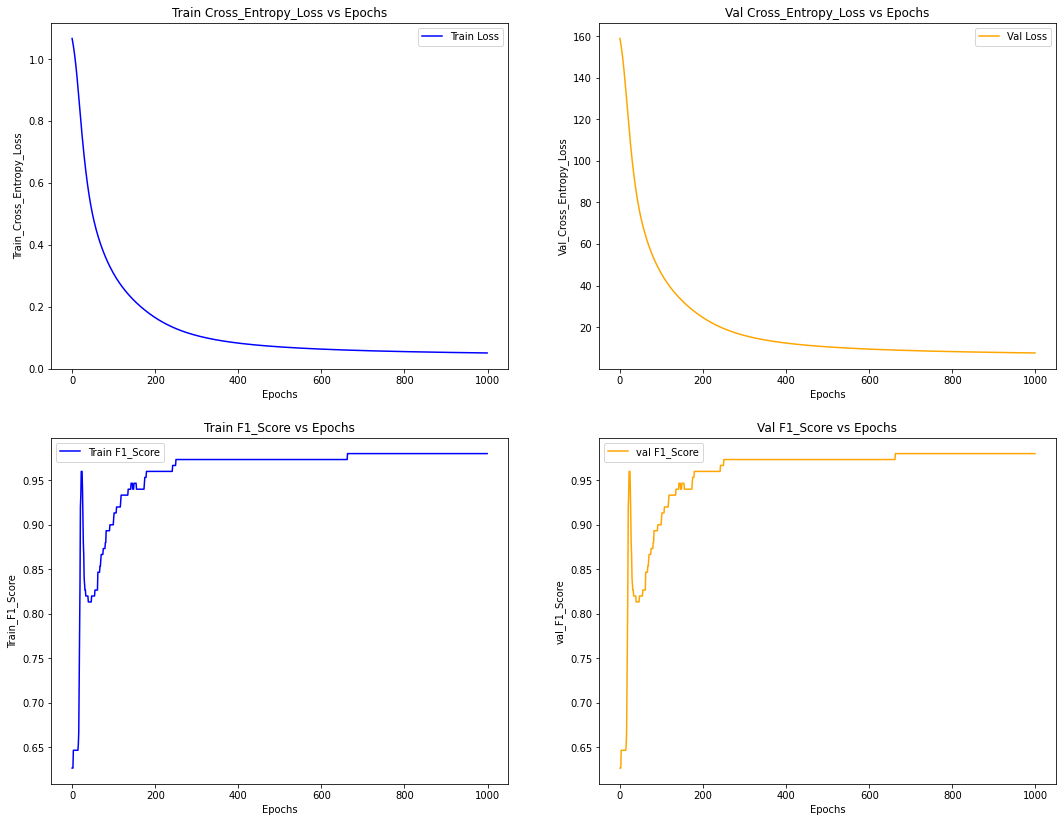

In [1813]:
Iris_Model.plot_training_curve(Loss_type = 'Cross_Entropy_Loss', score_metric = 'F1_Score')